In [166]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
import scipy.stats as stats

from sklearn import preprocessing


import warnings 
warnings.filterwarnings(action= 'ignore')

#### City of San Diego - Data SD
* Dataset name: Monitoring of Indicator Bacteria in Drinking Water
* URL: https://data.sandiego.gov/datasets/monitoring-of-indicator-bacteria-in-drinking-water/

In [113]:
# All Drinking Water Tests(Bacteria)
df = pd.read_csv('https://seshat.datasd.org/water_testing/indicator_bacteria_tests_datasd_v1.csv')
df.shape

(84320, 9)

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84320 entries, 0 to 84319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   FR_NUM        84320 non-null  int64  
 1   date_sampled  84320 non-null  object 
 2   source        84320 non-null  object 
 3   sample_id     84320 non-null  object 
 4   t_coliform    84216 non-null  object 
 5   cl2_total     84320 non-null  float64
 6   e_coli        84227 non-null  object 
 7   temperature   84320 non-null  float64
 8   ph            84320 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 5.8+ MB


In [115]:
# total observations with missing information
df.isnull().sum()

FR_NUM            0
date_sampled      0
source            0
sample_id         0
t_coliform      104
cl2_total         0
e_coli           93
temperature       0
ph                0
dtype: int64

In [116]:
# drop observations missing data
df.dropna(inplace=True)
df.shape

(84216, 9)

In [117]:
# if this results in only 0, then there is no more missing information
print('Unique row totals:')

for m in (set(df.isnull().sum())):
    print(m)

Unique row totals:
0


In [118]:
# sample of data
df.sample(5)

,FR_NUM,date_sampled,source,sample_id,t_coliform,cl2_total,e_coli,temperature,ph
33323,326131,2019-02-26,261 SYS,W1291068,A,0.29,A,18.4,7.91
2099,249641,2014-09-25,285 SYS,W1004725,A,1.91,A,29.4,8.08
74675,388106,2022-10-04,67 SYS,W1522525,A,2.61,A,25.2,8.30
37424,332510,2019-07-11,327 SYS,W1313387,A,1.76,A,24.1,7.96
37668,332986,2019-07-18,231 SYS,W1315876,A,2.15,A,25.4,7.91


In [119]:
# Data Dictionary
dict_df = pd.read_csv('https://seshat.datasd.org/water_testing/indicator_bacteria_tests_dictionary_datasd.csv').fillna('')
dict_df

,Field,Description,Possible values
0,sample_date,Date sample was taken,
1,site_ID,Unique identifier for the sample site,
2,temp_celsius,Temperature in Celsius,
3,chlorine,Chlorine in mg/l or ppm,
4,pH,pH of water sample,0-14
5,coliform,Presence of Coliform indicator bacteria,"A-Absent, P-Present"
6,E.coli,Presence of E.coli indicator bacteria,"A-Absent, P-Present"


In [120]:
# Value counts for t_coliform, to determine how to treat missing values
print(df.t_coliform.fillna("<").value_counts())

# Values A and P are valid according to dictionary, "missing" and "<" values will be removed
# Update 't_coliform' with "<" so that it is easier to delete in next step
df['t_coliform'] = df.t_coliform.fillna("<")

# Since missing values and "<" are not in data dictionary; delete rows
df = df.query("t_coliform != '<'")
print("\n","df shape after dropping t_coliform invalid rows:")
print(df.shape)

# Missing values re-check
print("\n")
print(df.t_coliform.fillna("<").value_counts())

A    83982
P      127
<      107
Name: t_coliform, dtype: int64

 df shape after dropping t_coliform invalid rows:
(84109, 9)


A    83982
P      127
Name: t_coliform, dtype: int64


In [121]:
# Data conversion
df['date_sampled'] =  pd.to_datetime(df.date_sampled)

In [122]:
print('''A value_counts for sample_id shows that there 
are multiple rows per sample_id:''')
df.sample_id.value_counts().head()

A value_counts for sample_id shows that there 
are multiple rows per sample_id:


W1283510    16
W1517915    16
W1517961    16
W1334315    16
W1518010    16
Name: sample_id, dtype: int64

In [123]:
print('''Querying the sample_id values above, shows that FR_NUM, date_sampled, source, 
sample_id, t_coliform, and e_coli are the same values for these multiple rows; however, 
cl2_total, temperature, and ph have similar values but not the same.''')

df.query("sample_id == 'W1377043'")

Querying the sample_id values above, shows that FR_NUM, date_sampled, source, 
sample_id, t_coliform, and e_coli are the same values for these multiple rows; however, 
cl2_total, temperature, and ph have similar values but not the same.


,FR_NUM,date_sampled,source,sample_id,t_coliform,cl2_total,e_coli,temperature,ph
48442,349455,2020-06-29,234A SYS,W1377043,A,0.89,A,23.3,8.24
48443,349455,2020-06-29,234A SYS,W1377043,A,0.89,A,23.3,8.28
48444,349455,2020-06-29,234A SYS,W1377043,A,0.89,A,23.5,8.24
48445,349455,2020-06-29,234A SYS,W1377043,A,0.89,A,23.5,8.28
48446,349455,2020-06-29,234A SYS,W1377043,A,0.89,A,23.3,8.24
48447,349455,2020-06-29,234A SYS,W1377043,A,0.89,A,23.3,8.28
48448,349455,2020-06-29,234A SYS,W1377043,A,0.89,A,23.5,8.24
48449,349455,2020-06-29,234A SYS,W1377043,A,0.89,A,23.5,8.28
48450,349455,2020-06-29,234A SYS,W1377043,A,0.90,A,23.3,8.24
48451,349455,2020-06-29,234A SYS,W1377043,A,0.90,A,23.3,8.28


In [124]:
# Create dataframe from value_counts to identify columns that can be updated, as they appear to be duplicates
df2 = df[['FR_NUM', 'date_sampled', 'source', 'sample_id']].value_counts().to_frame(name='Counts')

df2 = df2.reset_index() # places "Counts" into the header row with all other columns

# Only keep columns with Counts greater than 1
df2 = df2.query("Counts > 1")

# Merge values from original dataframe, to get averages for these rows requiring averages for duplicate rows
df2 = df2.merge(df, left_on=('FR_NUM', 'date_sampled', 'source', 'sample_id'), right_on=('FR_NUM', 'date_sampled', 'source', 'sample_id'), how="inner")

In [125]:
# Itirate through FR_NUM values to get averages from the means function above
# This process completes in around 1m 29s in Colab (+/- 22 seconds longer than local machine)

df2_means2 = []

for frn in (set(df2.FR_NUM)):

    df2_means2.append({'FR_NUM': frn,
                      'cl2_total_mean': df2.query("FR_NUM == @frn").cl2_total.mean(),
                      'temperature_mean': df2.query("FR_NUM == @frn").temperature.mean(),
                      'ph_mean': df2.query("FR_NUM == @frn").ph.mean()})

In [126]:
# Merge average values into original dataframe
df = df.merge(pd.DataFrame(df2_means), left_on=('FR_NUM'), right_on=('FR_NUM'), how="left")

In [127]:
# Make updates to features with variations
# The use of "left" in the merge statement above, left non-duplicate values empty; hence the accounting for them
# in the fillna statements below:
df['cl2_total'] = np.where(df.cl2_total_mean.fillna("") != "", df.cl2_total_mean, df.cl2_total)
df['temperature'] = np.where(df.temperature_mean.fillna("") != "", df.temperature_mean, df.temperature)
df['ph'] = np.where(df.ph_mean.fillna("") != "", df.ph_mean, df.ph)

In [128]:
# With all variations gone, we can now drop duplicates. The two df "shapes" below, are a before and after dropping duplicates.
df.drop_duplicates(inplace=True)
print('shape after dropping duplicates:')
print(df.shape)

shape after dropping duplicates:
(61482, 12)


In [136]:
print('''Verify that sample_id values are now unique (1 equals unique):''')
set(pd.DataFrame(set(df.sample_id)).value_counts().values)

Verify that sample_id values are now unique (1 equals unique):


{1}

In [137]:
# Drop unnecessary columns for remainder of the process - used in previous steps
df = df.drop(['cl2_total_mean', 'temperature_mean', 'ph_mean'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61482 entries, 0 to 84108
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   FR_NUM        61482 non-null  int64         
 1   date_sampled  61482 non-null  datetime64[ns]
 2   source        61482 non-null  object        
 3   sample_id     61482 non-null  object        
 4   t_coliform    61482 non-null  object        
 5   cl2_total     61482 non-null  float64       
 6   e_coli        61482 non-null  object        
 7   temperature   61482 non-null  float64       
 8   ph            61482 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 4.7+ MB


In [138]:
# View a 5 rows from head of file and 5 rows from tail of file
df

,FR_NUM,date_sampled,source,sample_id,t_coliform,cl2_total,e_coli,temperature,ph
0,244324,2014-06-05,244 SYS,W983115,A,1.91,A,23.4,8.02
1,244325,2014-06-05,245 SYS,W983116,A,1.77,A,24.3,7.99
2,244326,2014-06-05,66 SYS,W983117,A,1.95,A,25.5,8.02
3,244328,2014-06-05,250 SYS,W983119,A,2.40,A,22.6,8.02
4,244329,2014-06-05,248A SYS,W983120,A,1.82,A,24.2,7.96
...,...,...,...,...,...,...,...,...,...
84104,402674,2023-08-03,303A SYS,W1590460,A,3.20,A,22.7,8.22
84105,402675,2023-08-03,132 SYS,W1590461,A,1.90,A,28.9,7.91
84106,402676,2023-08-03,256 SYS,W1590462,A,2.50,A,24.7,8.00
84107,402677,2023-08-03,144 SYS,W1590463,A,2.30,A,24.3,7.86


In [139]:
# Based on the results from the above, it appears the data is ordered by date_sampled

# To ensure that all rows are following this pattern, the next step will 
# sort rows by date_sampled, source, and sample_id to get a chronological

df.sort_values(['date_sampled', 'FR_NUM'], ascending=[True, True], inplace=True)

In [140]:
# reset index, drop original index
df.reset_index(drop=True, inplace=True)

#### Outliers


In [141]:
# Outlier Analysis

# this function idea is from the Udemy "Feature Engineering for Machine Learning" course
def diagnostic_plots(df, variable):
    # function takes a dataframe and
    # the variable of interest

    # define plot figure size
    plt.figure(figsize=(16,4))

    # histogram
    plt.subplot(1,3,1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1,3,2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1,3,3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

In [142]:
# Function to find outliers by their respective high and low boundary, Gaussian distribution
# Got this idea from same Udemy video mentioned above
def find_normal_boundaries(df, variable, distance):

    upper_boundary = df[variable].mean() + distance * df[variable].std()
    lower_boundary = df[variable].mean() - distance * df[variable].std()

    return lower_boundary, upper_boundary

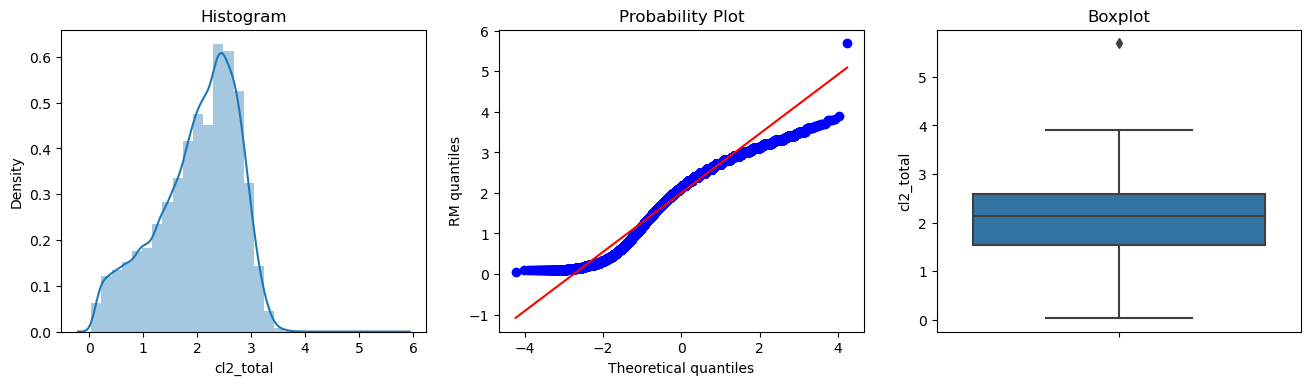

count    61482.000000
mean         2.003171
std          0.742809
min          0.040000
25%          1.530000
50%          2.140000
75%          2.590000
max          5.685000
Name: cl2_total, dtype: float64

In [143]:
diagnostic_plots(df, 'cl2_total')
df.cl2_total.describe()

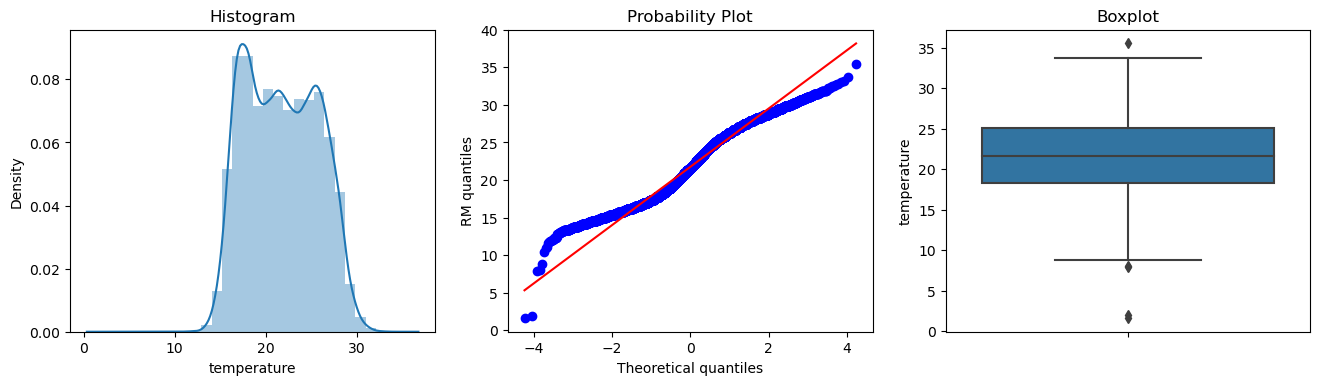

count    61482.000000
mean        21.753314
std          3.935716
min          1.630000
25%         18.300000
50%         21.600000
75%         25.100000
max         35.500000
Name: temperature, dtype: float64

In [144]:
diagnostic_plots(df, 'temperature')
df.temperature.describe()

In [145]:
# find lower and upper boundaries of 'temperature'
temperature_lower_limit, temperature_upper_limit = find_normal_boundaries(df, 'temperature', 3)

# Apply boundaries to outliers
df['temperature'] = np.where(df['temperature'] > temperature_upper_limit, temperature_upper_limit,
                     np.where(df['temperature'] < temperature_lower_limit, temperature_lower_limit,
                      df['temperature']))

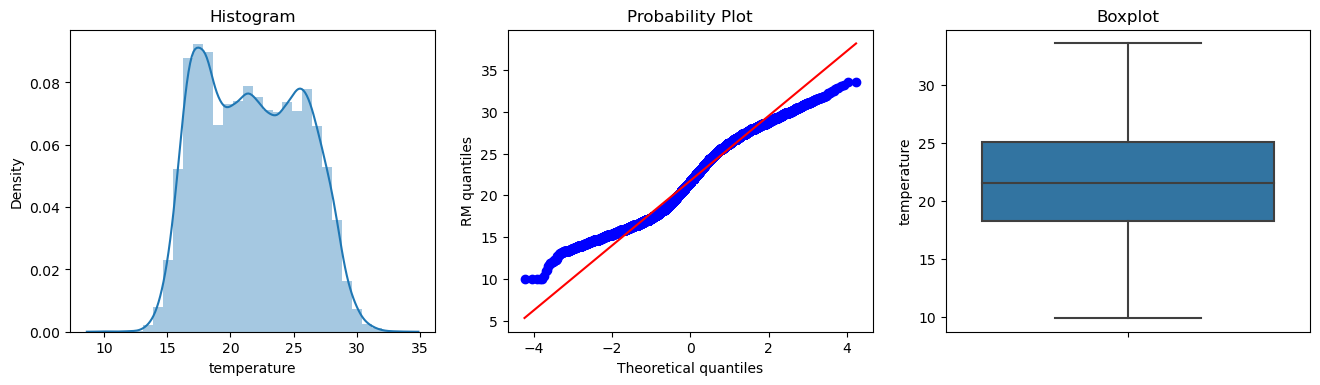

count    61482.000000
mean        21.753628
std          3.934267
min          9.946167
25%         18.300000
50%         21.600000
75%         25.100000
max         33.560460
Name: temperature, dtype: float64

In [146]:
# Verify changes to temperature feature
diagnostic_plots(df, 'temperature')
df.temperature.describe()

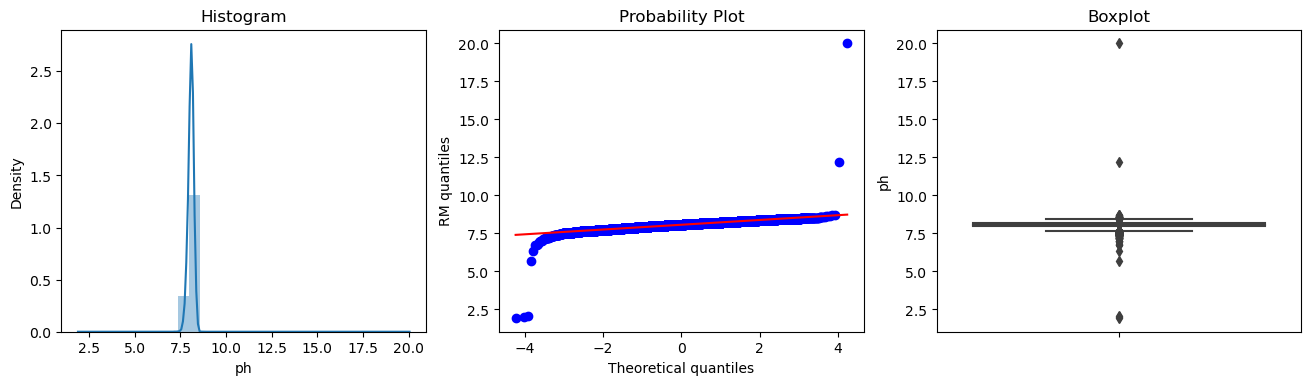

count    61482.000000
mean         8.074130
std          0.169642
min          1.940000
25%          7.980000
50%          8.090000
75%          8.180000
max         20.000000
Name: ph, dtype: float64

In [147]:
diagnostic_plots(df, 'ph')
df.ph.describe()

In [148]:
# find lower and upper boundaries of 'ph'
ph_lower_limit, ph_upper_limit = find_normal_boundaries(df, 'ph', 3)

# Apply boundaries to outliers
df['ph'] = np.where(df['ph'] > ph_upper_limit, ph_upper_limit,
                     np.where(df['ph'] < ph_lower_limit, ph_lower_limit,
                      df['ph']))

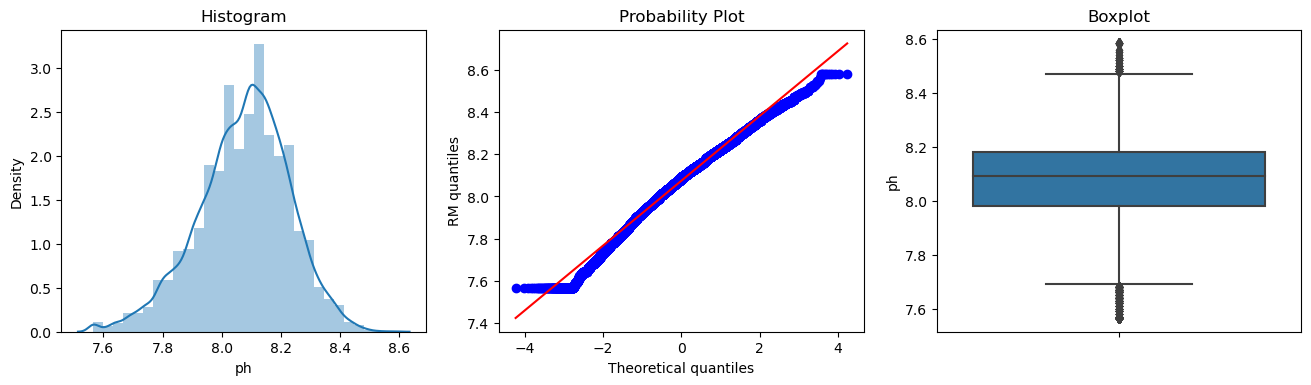

count    61482.000000
mean         8.074528
std          0.154369
min          7.565204
25%          7.980000
50%          8.090000
75%          8.180000
max          8.583057
Name: ph, dtype: float64

In [149]:
diagnostic_plots(df, 'ph')
df.ph.describe()

#### Business purpose (from website)

* A positive result for coliform from one single test is not enough to constitute an MCL (Maximum Contaminant Level) violation. An acute violation occurs when a site that initially tested positive is repeat tested and either the initial sample or one of the repeat samples is positive for E. coli. A monthly MCL violation occurs if more than 5 percent of all routine and repeat tests are coliform positive. A positive coliform result from a single routine test may be due to sampling error or bacteria in the testing mechanism but not in the drinking water pipes.

In [150]:
print('''There are no acute violations in the dataset, as all e_coli values equal 'A' 
across all {} rows, which is 'absent' e_coli.'''.format(pd.DataFrame(df.e_coli.value_counts()).iloc[0].values[0]))

df.e_coli.value_counts()

There are no acute violations in the dataset, as all e_coli values equal 'A' 
across all 61482 rows, which is 'absent' e_coli.


A    61482
Name: e_coli, dtype: int64

In [151]:
print('''A monthly MCL violation occurs if more than 5 percent of all routine and repeat tests are coliform positive. 
We have 'P', present, values in the t_coliform feature.''',"\n")

df.t_coliform.value_counts()

A monthly MCL violation occurs if more than 5 percent of all routine and repeat tests are coliform positive. 
We have 'P', present, values in the t_coliform feature. 



A    61375
P      107
Name: t_coliform, dtype: int64

#### Feature Engineering


In [152]:
# Adding a month-year value to best identify MCL violations
df['year'] = pd.DatetimeIndex(df.date_sampled).year
df['month'] = pd.DatetimeIndex(df.date_sampled).month
df['yearMonth'] =  df.year.astype(str) + '-' + df.month.astype(str)

In [153]:
# Identify yearMonth where t_coliform was Present, 'P'
ym_df = pd.DataFrame(df.query("t_coliform == 'P'").yearMonth.unique())
ym_df.columns = ['yearMonth']

# Get all data from df for yearMonth where there was t_coliform present
ym_df = df.merge(ym_df, left_on='yearMonth', right_on='yearMonth', how='inner')

In [154]:
# Crosstab results, into dataframe
ym_df = pd.DataFrame(pd.crosstab(ym_df.yearMonth, ym_df.t_coliform)).reset_index()

# Add a Total column
ym_df['Total'] = ym_df.A + ym_df.P

# Add a t_coli percent column, representing the percentage of cases in the month, when t_coli was Present
ym_df['yearMonth_t_coli_pct'] = round(ym_df.P / ym_df.Total * 100)

In [155]:
# Add yearMonth_t_coli_pct to main dataframe
df = df.merge(ym_df[['yearMonth', 'yearMonth_t_coli_pct']], left_on='yearMonth', right_on='yearMonth', how='left')

# Update Nan values to 0.0
df['yearMonth_t_coli_pct'] = df.yearMonth_t_coli_pct.fillna(0.0)


# Convert floats to integer
df['yearMonth_t_coli_pct'] = df.yearMonth_t_coli_pct.astype(int)

In [156]:
print('''There are no t_coliform instances per Month, of more than 5% in the dataset.
When present, it has equaled as high as 1% for the respective month only.''',"\n")
df.yearMonth_t_coli_pct.value_counts()

There are no t_coliform instances per Month, of more than 5% in the dataset.
When present, it has equaled as high as 1% for the respective month only. 



0    53094
1     8388
Name: yearMonth_t_coli_pct, dtype: int64

### EDA


##### Subset

In [157]:
df_subset = df[['date_sampled', 't_coliform', 'cl2_total', 'e_coli', 'temperature', 'ph', 'yearMonth_t_coli_pct']]

df_subset

,date_sampled,t_coliform,cl2_total,e_coli,temperature,ph,yearMonth_t_coli_pct
0,2014-06-02,A,2.80,A,22.8,8.03,0
1,2014-06-02,A,2.22,A,23.6,8.00,0
2,2014-06-02,A,1.95,A,25.5,7.99,0
3,2014-06-02,A,1.78,A,24.5,7.95,0
4,2014-06-02,A,2.70,A,22.2,8.02,0
...,...,...,...,...,...,...,...
61477,2023-08-03,A,3.20,A,22.7,8.22,0
61478,2023-08-03,A,1.90,A,28.9,7.91,0
61479,2023-08-03,A,2.50,A,24.7,8.00,0
61480,2023-08-03,A,2.30,A,24.3,7.86,0


##### Get dummies

In [158]:
df_dummies = pd.get_dummies(df_subset.select_dtypes(include='object'))

# join uses index as default on join
df_subset = df_subset.join(df_dummies, how='outer')

# drop 'object' columns
df_subset.drop(columns=df_subset.select_dtypes(include='object').columns.tolist(), inplace=True)

df_subset

,date_sampled,cl2_total,temperature,ph,yearMonth_t_coli_pct,t_coliform_A,t_coliform_P,e_coli_A
0,2014-06-02,2.80,22.8,8.03,0,1,0,1
1,2014-06-02,2.22,23.6,8.00,0,1,0,1
2,2014-06-02,1.95,25.5,7.99,0,1,0,1
3,2014-06-02,1.78,24.5,7.95,0,1,0,1
4,2014-06-02,2.70,22.2,8.02,0,1,0,1
...,...,...,...,...,...,...,...,...
61477,2023-08-03,3.20,22.7,8.22,0,1,0,1
61478,2023-08-03,1.90,28.9,7.91,0,1,0,1
61479,2023-08-03,2.50,24.7,8.00,0,1,0,1
61480,2023-08-03,2.30,24.3,7.86,0,1,0,1


#### get dummies for year

In [23]:
### get dummies for year

##### Target variable imbalance

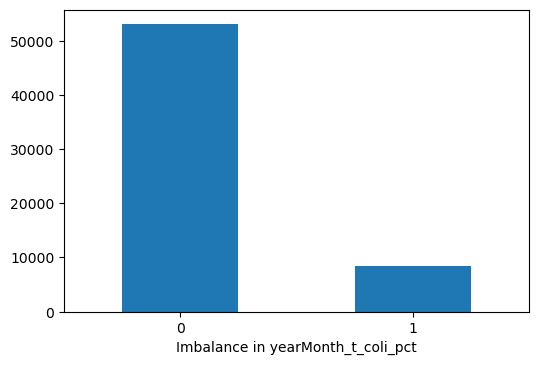

In [159]:
df_subset.yearMonth_t_coli_pct.value_counts().plot(kind='bar', rot=0)
plt.xlabel('Imbalance in yearMonth_t_coli_pct')
plt.show()

#### Balance target

In [160]:
df_subset.yearMonth_t_coli_pct

0        0
1        0
2        0
3        0
4        0
        ..
61477    0
61478    0
61479    0
61480    0
61481    0
Name: yearMonth_t_coli_pct, Length: 61482, dtype: int64

##### Pairplot of numerical variables

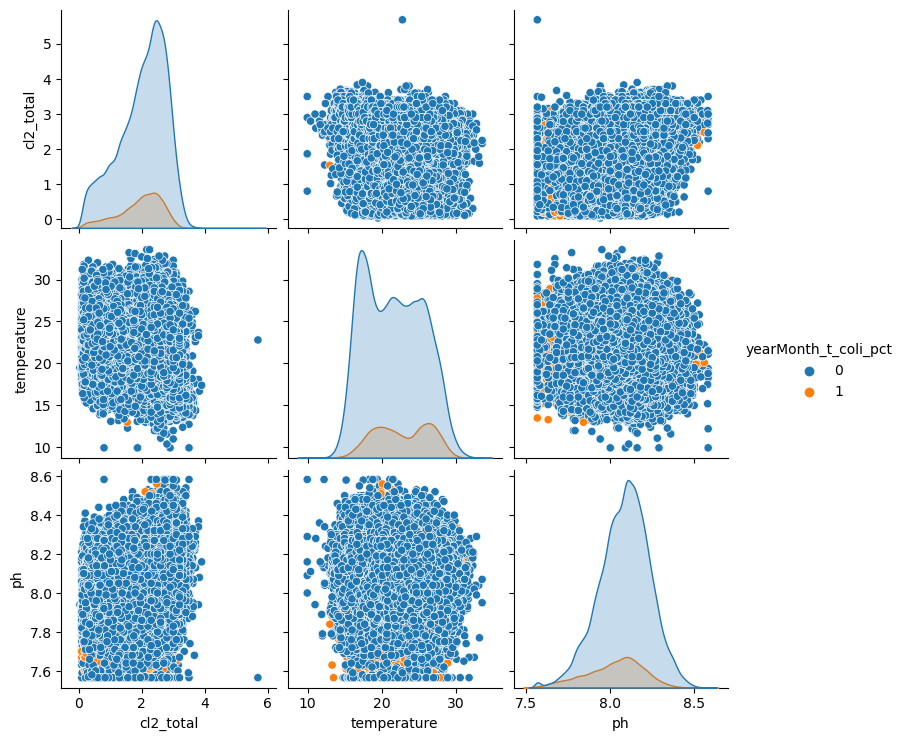

In [161]:
sns.pairplot(df_subset.select_dtypes(include=['float64', 'int64', 'int32']), hue='yearMonth_t_coli_pct')
plt.show()

### Create a Target classifier, representing a source that had t_coliform present at any point in the dataset.
### source_t_coliform_historically

In [163]:
# Identify 'source' which has had t_coliform in the past
source_df = pd.DataFrame(df.query("t_coliform == 'P'").source.unique())
source_df.columns = ['source']
source_df['source_t_coliform_historically'] = 1

In [164]:
# Merge source_df into main dataframe
df = df.merge(source_df, left_on='source', right_on='source', how='left')

# Convert missing values to 0
df['source_t_coliform_historically'] = df.source_t_coliform_historically.fillna(0)

# Convert to int
df['source_t_coliform_historically'] = df.source_t_coliform_historically.astype(int)

In [167]:
# initiate sklearn LabelEncoder
le = preprocessing.LabelEncoder()

# LabelEncoder 'source' feature
le.fit(df['source'])
df['source_le'] =  le.transform(df['source'])

# LabelEncoder 'yearMonth' feature
le.fit(df['yearMonth'])
df['yearMonth_le'] =  le.transform(df['yearMonth'])

In [168]:
# Binary values for t_coliform
df['t_coliform_bin'] = np.where(df.t_coliform == 'A', 0, 1)

## Proposed target variable

<AxesSubplot:>

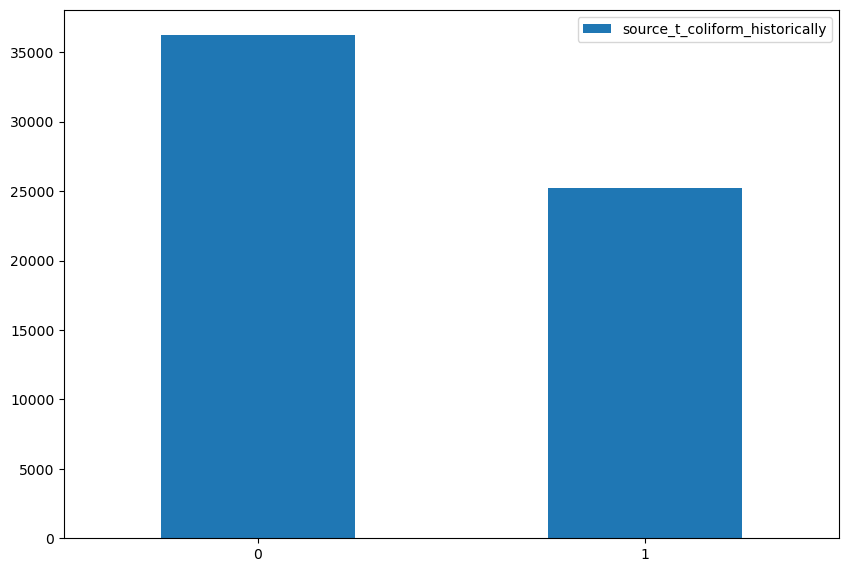

In [169]:
# More than half of the "sources" have had t_coliform present at some point
pd.DataFrame(df.source_t_coliform_historically.value_counts()).plot.bar(rot=0, stacked=True, figsize=(10,7))

This graph shows ticks for the year when a label encoded source, had t_coliform present,
between the years 2015 through 2018. This is in effort to try and recognize patterns of recurring 
t_coliform at specific sources during this stretch of time. 



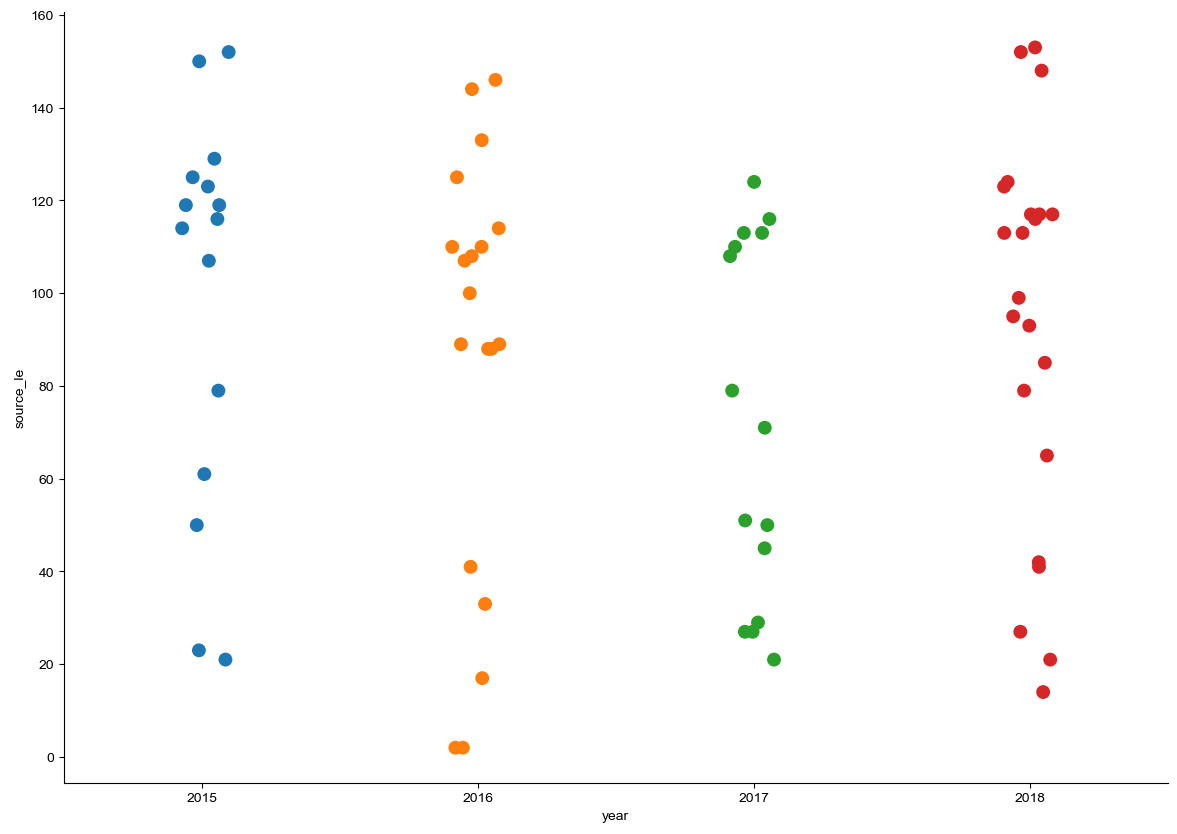

In [170]:
print('''This graph shows ticks for the year when a label encoded source, had t_coliform present,
between the years 2015 through 2018. This is in effort to try and recognize patterns of recurring 
t_coliform at specific sources during this stretch of time.''',"\n")

sns.catplot(data=df.query("t_coliform_bin == 1 and year <= 2018 and year >= 2015"), x='year', y='source_le', s=10, height=8.27, aspect=11.7/8.27)
sns.set_style("ticks",{'axes.grid' : True})

<AxesSubplot:>

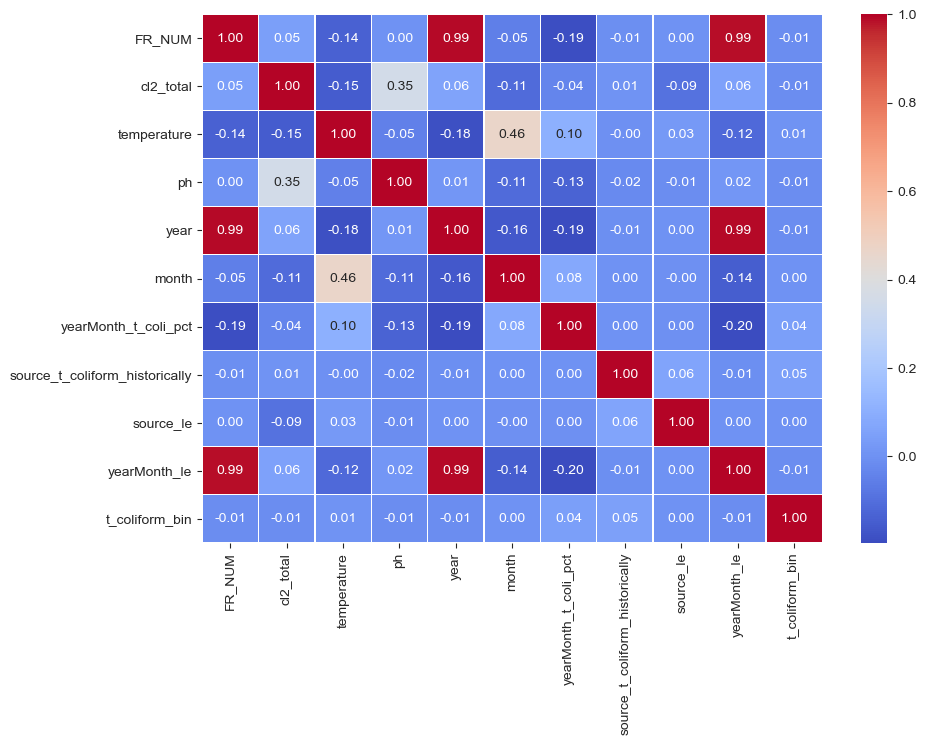

In [171]:
# Correlation Matrix
pearsoncorr = df.corr(method='pearson')

plt.figure(figsize= (10, 7))

sns.heatmap(pearsoncorr,
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='coolwarm',
            fmt=".2f",
            annot=True,
            linewidth=0.25)